## Define network

In [1]:
import torch
from torch import nn
from src.transformers import ViT, Decoder

torch.manual_seed(0)


class Net(nn.Module):
    def __init__(self, embed_dim=8):
        super(Net, self).__init__()

        self.encoder = ViT(embed_dim=embed_dim, n_blocks=1, n_heads=2)

        self.decoder = Decoder(embed_dim=embed_dim,
                               n_blocks=1, encoder_dim=embed_dim, n_heads=1)

        self.mapper = nn.Linear(3, embed_dim)

        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, 3),
            nn.Sigmoid()
        )

    def forward(self, x, p, mask=None):
        x = self.encoder(x)
        p = self.mapper(p)
        x = self.decoder(p, x[:, 0, :], mask)
        x = self.mlp(x)

        return x

## Define dataset anda dataloader

In [2]:
from src.datasets import PolyMNIST
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

train = PolyMNIST(csv_file="mnist/train/polygon-mnist.csv",
                  transform=ToTensor())

test = PolyMNIST(csv_file="mnist/test/polygon-mnist.csv",
                 transform=ToTensor())

train_loader = DataLoader(train, batch_size=30, shuffle=True)
test_loader = DataLoader(test, batch_size=30, shuffle=False)

## Train

In [3]:
from torch.optim import Adam
from torch.nn import MSELoss
from tqdm.notebook import trange, tqdm
import torch

N_EPOCHS = 5
LR = 0.001

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device_name = torch.cuda.get_device_name(
    device) if torch.cuda.is_available() else "cpu"
print("Using device: ", device, f"({device_name})")

mask = torch.tril(torch.ones(12, 12)).view(1, 12, 12).to(device)

model = Net().to(device)
optimizer = Adam(model.parameters(), lr=LR)
criterion = MSELoss()

train_loss = 0.0
for epoch in trange(N_EPOCHS, desc="Training"):
    model.train()

    train_loss = 0.0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1} in training", leave=False):
        image, _, polygon = batch

        image = image.to(device)
        polygon = polygon.to(device)

        pred = model(image, polygon, mask)
        loss = criterion(pred[:, :-1, :], polygon[:, 1:, :])

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item() / len(train_loader)

    print(f"Epoch {epoch + 1}/{N_EPOCHS} loss: {train_loss:.4f}")

    with torch.no_grad():
        correct, total = 0, 0
        test_loss = 0.0
        model.eval()
        for batch in tqdm(test_loader, desc="Testing"):
            x, _, p = batch
            x, p = x.to(device), p.to(device)

            pred = model(image, polygon, mask)
            loss = criterion(pred[:, :-1, :], polygon[:, 1:, :])

            test_loss += loss.detach().cpu().item() / len(test_loader)

            # correct += torch.sum(torch.argmax(y_hat, dim=1)
            #                      == y).detach().cpu().item()
            total += len(x)
        print(f"Test loss: {test_loss:.4f}")
    # print(f"Test accuracy: {correct / total * 100:.2f}%")

Using device:  cuda (NVIDIA GeForce GTX 1050)


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1 in training:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 1/5 loss: 0.0166


Testing:   0%|          | 0/334 [00:00<?, ?it/s]

Test loss: 0.0099


Epoch 2 in training:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 2/5 loss: 0.0088


Testing:   0%|          | 0/334 [00:00<?, ?it/s]

Test loss: 0.0080


Epoch 3 in training:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 3/5 loss: 0.0079


Testing:   0%|          | 0/334 [00:00<?, ?it/s]

Test loss: 0.0070


Epoch 4 in training:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 4/5 loss: 0.0075


Testing:   0%|          | 0/334 [00:00<?, ?it/s]

Test loss: 0.0068


Epoch 5 in training:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 5/5 loss: 0.0073


Testing:   0%|          | 0/334 [00:00<?, ?it/s]

Test loss: 0.0068


## Show

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8


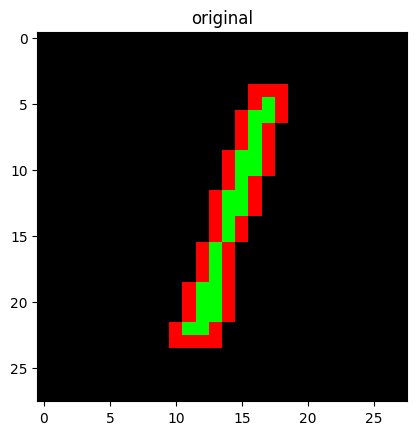

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
%matplotlib inline

batch_images, _, poly = next(iter(test_loader))
idx = 2

img = batch_images[idx].numpy()[0] * 255
img = img.astype(np.uint8)

np_out = np.zeros((28,28, 3))
np_out[:,:, 1] = np.copy(img)

n = poly[idx].numpy()

last_idx = np.where(n[:, 0] == 1)[0][0]
n = n[1:last_idx]

print(last_idx)
n = np.delete(n, 0, 1).reshape(-1, 1, 2) * 28
n = n.astype(np.int32)
image = cv2.polylines(np_out, [n], True, (255,0,0), 1)

plt.title("original")
plt.imshow(image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([0.0908, 0.1871, 0.2623, 0.3502, 0.4332, 0.5310, 0.6116, 0.6969, 0.7949,
        0.9064], device='cuda:0')


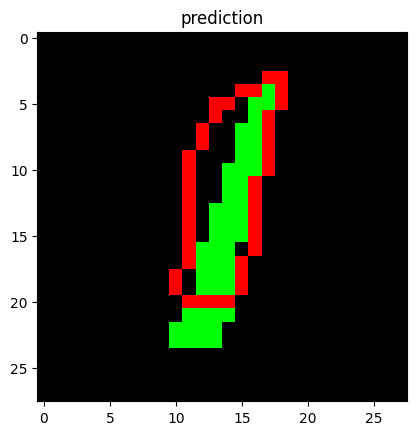

In [10]:
with torch.no_grad():
    inputs = torch.zeros(1, 1, 3).to(device)
    image = batch_images[idx].reshape(1, 1, 28, 28).to(device)

    poly_helper = []
    for i in range(11):
        pred = model(image, inputs, mask[:, :i + 1, :i + 1])

        if (pred[0, -1, 0] > 0.95):
            break
        poly_helper.append(pred[:, -1, :])

        inputs = torch.cat((inputs, pred[:, -1, :].view(1, 1, -1)), dim=1)
    poly_helper = torch.cat(poly_helper)

    np_out = np.zeros((28, 28, 3))
    np_out[:, :, 1] = np.copy(img)

    print(poly_helper[:, 0])
    n = poly_helper.to('cpu').numpy() * 28
    n = np.delete(n, 0, 1).reshape(-1, 1, 2)
    n = n.astype(np.int32)
    image = cv2.polylines(np_out, [n], True, (255, 0, 0), 1)

    plt.title("prediction")
    plt.imshow(image)

## Save

In [11]:
path = "checkpoints/poly_mask_001.pth"
torch.save(model.state_dict(), path)